In [1]:
# ! pip install open-clip-torch matplotlib

In [49]:
import numpy as np
import os
import torch
from torchvision import transforms
from tqdm import tqdm


import PIL

import matplotlib.pyplot as plt


In [58]:
import open_clip
from open_clip import tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e32')

100%|████████████████████████████████████████| 605M/605M [00:02<00:00, 226MiB/s]


In [59]:
data_format = ".png"
if data_format == ".npy":
    data = np.load('/cluster/scratch/nkoisheke/gen_images.npy')
else:
    data = []
    # change the image folders here
    path = "/cluster/scratch/nkoisheke/artstation_1_5/"
    number_of_images = len(os.listdir(path))
    print(number_of_images)
    for i in range(number_of_images):
        img = PIL.Image.open(path + str(i) + ".png")
        data.append(img)
        
    

3960


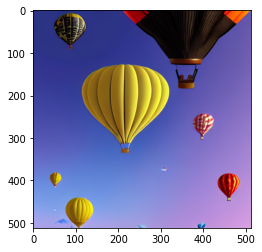

In [60]:
%matplotlib inline

temp_image = data[0]

plt.imshow(temp_image)

# Check on generated images

## Get image features

In [61]:
device = torch.device('cuda')
model.to(device);

In [62]:
image_features = []
batch_size = 512

with torch.no_grad():
    for i in tqdm(range(0, len(data), batch_size)):
        batch = []
        for j in range(i, min(i+batch_size, len(data))):
            if data_format == ".npy":
                img = PIL.Image.fromarray(data[j])
            else:
                img = data[j]
            img = preprocess(img)
            batch.append(img)
    
        batch = torch.tensor(np.stack(batch))
        batch = batch.to(device)
        img_feats = model.encode_image(batch).float()
        image_features.append(img_feats)
image_features_torch = torch.concatenate(image_features).cpu()

100%|██████████| 8/8 [00:48<00:00,  6.04s/it]


In [63]:
# save the model
torch.save(image_features_torch, '/cluster/scratch/nkoisheke/artstation_sd_1_5_' + 'laion400m_e32_ViT-B-32' + '.pt')

 Clean the data

In [64]:
del data

In [65]:
image_features_torch.shape

torch.Size([3960, 512])

## Get text features

In [66]:
# read csv file
import pandas as pd
df = pd.read_csv('/cluster/scratch/nkoisheke/gen_images_artstation_1_5.csv')
df.head()

print(df.shape)

(3960, 5)


In [67]:
artists = df['artist'].unique()
text_features = []

with torch.no_grad():
    for artist in artists:
        prompt = "The following work is done in the style of " + artist
        text_tokens = tokenizer.tokenize(prompt)
        text_tokens = text_tokens.to(device)
        txt_feat = model.encode_text(text_tokens).float()
        text_features.append(txt_feat)
text_features_torch = torch.concatenate(text_features).cpu()

In [68]:
idx2artist = {}
artist2idx = {}
for i, artist in enumerate(artists):
    idx2artist[i] = artist
    artist2idx[artist] = i

## Compute cosine similarity

In [69]:
image_features_torch /= image_features_torch.norm(dim=-1, keepdim=True)
text_features_torch /= text_features_torch.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features_torch @ text_features_torch.T).softmax(dim=-1)
top_probs, top_k_labels = text_probs.cpu().topk(5, dim=-1)

In [70]:
gt_labels = torch.tensor([artist2idx[x] for x in df['artist'].to_list()])

top_one_labels = top_k_labels[:, 0]

print(gt_labels.shape, top_one_labels.shape)

correct = (gt_labels == top_one_labels).sum()
print(f"Top 1 score is {round((correct / gt_labels.shape[0]).item() * 100, 2)}")


topk_correct = 0
for i in range(5):
    top_one_labels = top_k_labels[:, i]
    correct = (gt_labels == top_one_labels).sum()
    topk_correct += correct
print(f"Top 5 score is {round((topk_correct / gt_labels.shape[0]).item() * 100, 2)}")
# correct = (gt_labels.repeat() == top_k_labels).sum()
# print(correct)

torch.Size([3960]) torch.Size([3960])
Top 1 score is 0.73
Top 5 score is 3.21


In [ ]:
#get artist with their mean probability
artist_probs = {}
for i in range(len(artists)):
    artist_probs[artists[i]] = text_probs[:, i].mean().item()
artist_probs = {k: v for k, v in sorted(artist_probs.items(), key=lambda item: item[1], reverse=True)}
#higher 5 and lower 5
print("Top 5")
for name, value in list(artist_probs.items())[:5]:
    print(f"{name}: {value}")
print("Bottom 5")
for name, value in list(artist_probs.items())[-5:]:
    print(f"{name}: {value}")

In [ ]:
#get prompts with their mean probability
prompts = {}
for i in range(len(df)):
    prompt = df['prompt'][i]
    if prompt not in prompts:
        prompts[prompt] = text_probs[i, artist2idx[df['artist'][i]]].item()
prompts = {k: v for k, v in sorted(prompts.items(), key=lambda item: item[1], reverse=True)}
print("Top 5")
for name, value in list(prompts.items())[:5]:
    print(f"{name}: {value}")
print("Bottom 5")
for name, value in list(prompts.items())[-5:]:
    print(f"{name}: {value}")

In [ ]:
#artist probabilities to dataframe and then to csv
df_artists = pd.DataFrame.from_dict(artist_probs, orient='index', columns=['probability'])
#df_artists.to_csv('../error_analysis/artist_probs_sd_1_5_laion2b_s34b_b79k_ViT-B-32.csv')

In [ ]:
#prompt probabilities to dataframe and then to csv
df_prompts = pd.DataFrame.from_dict(prompts, orient='index', columns=['probability'])
#df_prompts.to_csv('../error_analysis/prompt_probs_sd_1_5_laion2b_s34b_b79k_ViT-B-32.csv')

# Check on real images

In [22]:
import os
path = "/cluster/scratch/nkoisheke/artworks_images/"
df = pd.read_csv('../Scraping/googleart/Data/googleart_art_data_final.csv', sep='\t')

In [23]:
df.head()

,artist_name,artwork_title,artwork_date,artwork_url,image_url,image_path
0,Vincent van Gogh,Self-Portrait,1889,https://artsandculture.google.com/asset/self-p...,blob:https://artsandculture.google.com/46b00d1...,./Scraping/googleart/Data/artworks_images/imag...
1,Vincent van Gogh,The Starry Night,1889,https://artsandculture.google.com/asset/the-st...,blob:https://artsandculture.google.com/30b15a6...,./Scraping/googleart/Data/artworks_images/imag...
2,Vincent van Gogh,Almond Blossom,February 1890 - 1890,https://artsandculture.google.com/asset/almond...,blob:https://artsandculture.google.com/78cc161...,./Scraping/googleart/Data/artworks_images/imag...
3,Vincent van Gogh,Country road in Provence by night,c. 12 - 15 May 1890,https://artsandculture.google.com/asset/countr...,blob:https://artsandculture.google.com/4873671...,./Scraping/googleart/Data/artworks_images/imag...
4,Vincent van Gogh,Starry Night,1888,https://artsandculture.google.com/asset/starry...,blob:https://artsandculture.google.com/fe464bc...,./Scraping/googleart/Data/artworks_images/imag...


In [24]:
image_paths = [path + img.split('/')[-1] for img in df["image_path"].to_list()]

## Get image features

In [25]:
image_features = []
batch_size = 64

with torch.no_grad():
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = []
        for j in range(i, min(i+batch_size, len(image_paths))):
            img = PIL.Image.open(image_paths[j])
            img = preprocess(img)
            batch.append(img)
        batch = torch.tensor(np.stack(batch))
        img_feats = model.encode_image(batch).float()
        image_features.append(img_feats)
image_features_torch = torch.concatenate(image_features)

100%|██████████| 19/19 [01:24<00:00,  4.46s/it]


In [26]:
artists = df['artist_name'].unique()
text_features = []

with torch.no_grad():
    for artist in artists:
        prompt = "The following work is done in the style of " + artist
        text_tokens = tokenizer.tokenize(prompt)
        txt_feat = model.encode_text(text_tokens).float()
        text_features.append(txt_feat)
text_features_torch = torch.concatenate(text_features)

## Compute probabilities

In [27]:
image_features_torch /= image_features_torch.norm(dim=-1, keepdim=True)
text_features_torch /= text_features_torch.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features_torch @ text_features_torch.T).softmax(dim=-1)
top_probs, top_k_labels = text_probs.cpu().topk(5, dim=-1)

In [28]:
gt_labels = torch.tensor([artist2idx[x] for x in df['artist_name'].to_list()])

top_one_labels = top_k_labels[:, 0]

print(gt_labels.shape, top_one_labels.shape)

correct = (gt_labels == top_one_labels).sum()
print(f"Top 1 score is {round((correct / gt_labels.shape[0]).item() * 100, 2)}")


topk_correct = 0
for i in range(5):
    top_one_labels = top_k_labels[:, i]
    correct = (gt_labels == top_one_labels).sum()
    topk_correct += correct
print(f"Top 5 score is {round((topk_correct / gt_labels.shape[0]).item() * 100, 2)}")
# correct = (gt_labels.repeat() == top_k_labels).sum()
# print(correct)

torch.Size([1181]) torch.Size([1181])
Top 1 score is 55.63
Top 5 score is 79.51


In [ ]:
#get artist with their mean probability
artist_probs = {}
for i in range(len(artists)):
    artist_probs[artists[i]] = text_probs[:, i].mean().item()
artist_probs = {k: v for k, v in sorted(artist_probs.items(), key=lambda item: item[1], reverse=True)}
#higher 5 and lower 5
print(list(artist_probs.items())[:5])
print(list(artist_probs.items())[-5:])